# Quick start guide
This tutorial will show you how to utilize the 'livecellx' package to extract sinlge cell trajectories from long live-cell imaging data by segmenting and tracking single cells, and then compute single cell features in a latent space.

In [1]:
# import some common libraries
import os
import glob
import os.path
import numpy as np
import json, random, cv2
from cellpose import models
from cellpose.io import imread
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
from skimage import measure
from PIL import Image, ImageSequence

# from livecellx import core
from livecellx import core
from livecellx.core import datasets
from livecellx.core import SingleCellTrajectory, SingleCellStatic
from livecellx.core.datasets import LiveCellImageDataset, SingleImageDataset

## Loading single cells from sample data

```LiveCellImageDataset, SingleCellImageDataset``` from livecellx.core.datasets allow users to load images with ease, without reading directly into memories. Both of two classes are designed to help manage and interact with datasets of live cell images. `SingleCellImageDataset` takes a single image from the memory and makes it a single time point dataset, which can be handy when you would like to process imaging datasets. 

Now, we download sample datasets and prepare the single cell datasets from the mask and DIC datasets. This is the step where we convert our image data into a format that's easy to work with for segmenting and tracking single-cells.

In [2]:
from skimage.measure import regionprops
from livecellx.core.io_sc import prep_scs_from_mask_dataset
from livecellx.sample_data import tutorial_three_image_sys

dic_dataset, mask_dataset = tutorial_three_image_sys()
single_cells = prep_scs_from_mask_dataset(mask_dataset, dic_dataset)

|-----> Downloading data to datasets\test_data_STAV-A549.zip
|-----> Data already exists at datasets\test_data_STAV-A549.zip
|-----> Extracting data to datasets
3 png img file paths loaded;
3 tif img file paths loaded;


100%|██████████| 3/3 [00:08<00:00,  2.88s/it]


We want to ensure that the preparation of single cell datasets was successful, and each dataset has the associated mask data.

In [3]:
for sc in single_cells:
    assert sc.mask_dataset

Check the total number of single cell datasets prepared.

In [4]:
len(single_cells)

42

### Organizing single cells by timeframe
We aim to organize the single cell datasets based on the timeframes they belong to.

In [5]:
single_cells_by_time = {}
for cell in single_cells:
    if cell.timeframe not in single_cells_by_time:
        single_cells_by_time[cell.timeframe] = []
    single_cells_by_time[cell.timeframe].append(cell)

Now, let's have a confirmation on how many single cell datasets we have for each timeframe. This provides a quick overview of the data distribution across time.

In [6]:
for time in single_cells_by_time:
    print(time, len(single_cells_by_time[time]))

0 13
1 14
2 15


### Visualizing one single cell

To better understand the single cell data we have, let's visualize one of the single cells using different representations.

In [7]:
sc = single_cells[1]

#fig, axes = plt.subplots(1, 4, figsize=(10, 5))
#sc.show(ax=axes[0])  # show raw image
#sc.show_mask(ax=axes[1])  # show mask
#sc.show_contour_img(ax=axes[2])  # show contour image
#sc.show_contour_mask(ax=axes[3])  # show contour mask

Compact Visualization using show_panel to visualize all the above representations and cropped images in a single call.

array([<Axes: title={'center': 'img'}>, <Axes: title={'center': 'mask'}>,
       <Axes: title={'center': 'contour_img'}>,
       <Axes: title={'center': 'contour_mask'}>,
       <Axes: title={'center': 'label_crop'}>,
       <Axes: title={'center': 'img_crop'}>], dtype=object)

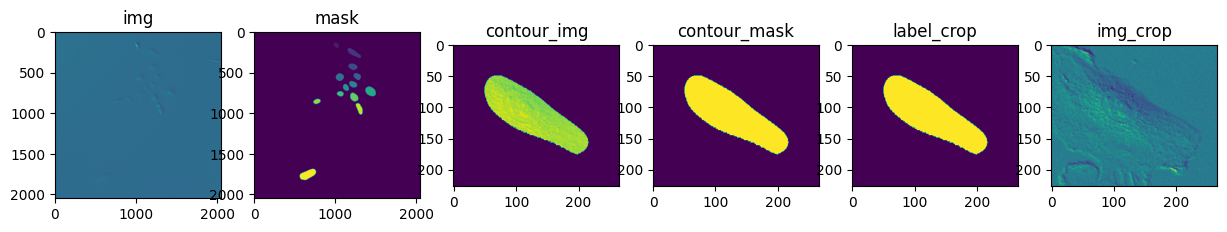

In [8]:
sc.show_panel(padding=50, figsize=(15, 5))

### Preprocessing cell image
In this block, preprocessing is performed on the cell image to ensure better accuracy and effectiveness in further analysis. This involves normalizing the original image (`normalize_img_to_uint8`), correcting the background using two different algorithms (`correct_background_bisplrep` and `correct_background_median_gamma`), and ensuring the image data is suitable for visualization and analysis.

In [9]:
import scipy
import numpy as np
from skimage import morphology
import scipy.interpolate as interp

from livecellx.preprocess.utils import normalize_img_to_uint8
from livecellx.preprocess.correct_bg import correct_background_bisplrep, correct_background_median_gamma


# Selecting a single cell from the dataset
sc = single_cells[0].copy()

padding_size = 30
# Showing the cropped image of the single cell
# sc.show(crop=True)
# Obtaining the cropped image of the single cell
sc_img = sc.get_img_crop(padding=padding_size)
original_sc = sc_img

# Normalizing the image and correcting the background using the B-spline representation method
bisplrep_sc_img = normalize_img_to_uint8(sc_img)
bisplrep_sc_img = correct_background_bisplrep(sc_img, sample_step=5, s=1e20)

# Normalizing the image and correcting the background using median gamma correction method
gamma_sc_img = sc.get_img_crop(padding=padding_size)
gamma_sc_img = normalize_img_to_uint8(sc_img)
gamma_sc_img = correct_background_median_gamma(sc_img, disk_size=2)

c:\Users\13290\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\filters\rank\generic.py:268: UserWarning: Bad rank filter performance is expected due to a large number of bins (34545), equivalent to an approximate bitdepth of 15.1.
  image, footprint, out, mask, n_bins = _preprocess_input(image, footprint,


### Visualizing background correction results
This block visualizes the results of the background correction to provide a clear comparison of the original image and the corrected images using two different background correction algorithms.

Text(0.5, 1.0, 'corrected: gamma correction')

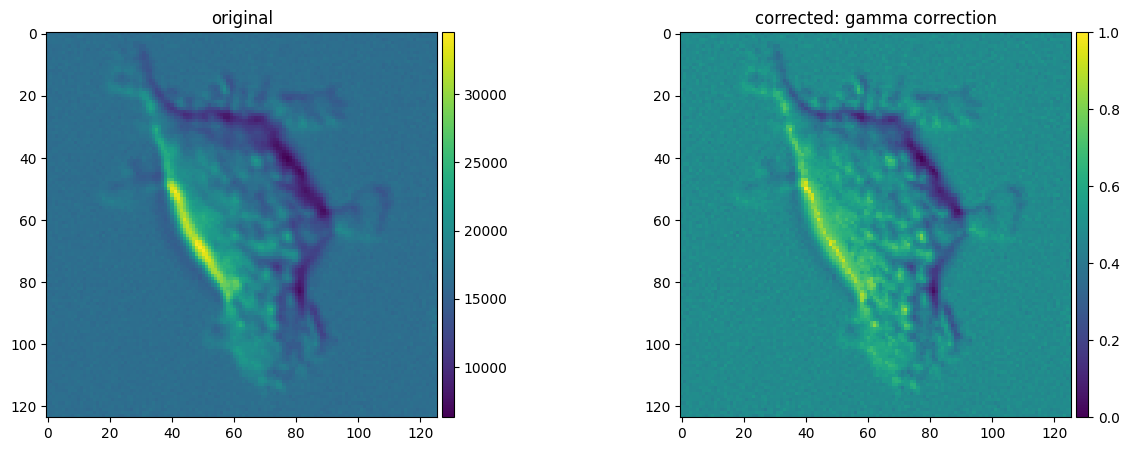

In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def add_colorbar(im, ax, fig):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05)
    fig.colorbar(im, cax=cax, orientation="vertical")
    
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
im = axes[0].imshow(original_sc)
# show colorbar
add_colorbar(im, axes[0], fig)
axes[0].set_title("original")

im = axes[1].imshow(gamma_sc_img)
add_colorbar(im, axes[1], fig)
axes[1].set_title("corrected: gamma correction")


We select Cells for Analysis

In [11]:
sc1 = single_cells[1]
sc2 = single_cells[2]

## Calculating cell features

Now we'll calculate a variety of features for sc1. 

In [12]:
from livecellx.trajectory.feature_extractors import compute_skimage_regionprops, compute_haralick_features

skimage_features = compute_skimage_regionprops(sc1)
sc1.add_feature("skimage", skimage_features)

In [13]:
# Optionally, you can also calculate Haralick texture features for the cell
# Uncomment the below lines to calculate Haralick features

# haralick_features = compute_haralick_features(sc1)
# sc1.add_feature("haralick", haralick_features)

These features will provide quantitative information about the cell which could be used in many ways, including in tracking and analysis tasks.

In [14]:
sc1.get_feature_pd_series()

skimage_area                  9375.000000
skimage_area_bbox            20916.000000
skimage_area_convex           9728.000000
skimage_area_filled           9375.000000
skimage_axis_major_length      199.544403
                                 ...     
skimage_orientation              1.008517
skimage_perimeter              472.457936
skimage_perimeter_crofton      450.599728
skimage_solidity                 0.963713
t                                0.000000
Length: 144, dtype: float64

We show bounding box of the cell

In [15]:
sc2.bbox

array([ 400, 1158,  479, 1269])

We calculate overlap between two single cells

In [16]:
sc1.compute_iou(sc2), sc1.compute_overlap_percent(sc2)

(0.0, 0.0)

## Tracking based on single cells
In this section, we leverage the SORT (Simple, Online and Realtime Tracking) algorithm to track cells across different frames based on their bounding boxes. This helps in understanding the movement and transformation of cells over time.

In [17]:
from typing import List
from livecellx.track.sort_tracker_utils import (
    gen_SORT_detections_input_from_contours,
    update_traj_collection_by_SORT_tracker_detection,
    track_SORT_bbox_from_contours,
    track_SORT_bbox_from_scs
)


traj_collection = track_SORT_bbox_from_scs(single_cells, dic_dataset, mask_dataset=mask_dataset, max_age=0, min_hits=1)

### Generating movies
Now that we have tracked the cells, we can generate movies to visualize the tracking process. This block also checks for any cells that were discarded or newly detected during the tracking process which can be informative for understanding the tracking performance and cellular dynamics.

In [18]:
new_scs = []
for _, sct in traj_collection:
    new_scs.extend(sct.get_all_scs())
new_scs_ids = {sc.id for sc in new_scs}
old_scs_ids = {sc.id for sc in single_cells}
for sc in single_cells:
    if not (sc.id in new_scs_ids):
        print("sc:", sc.id, "is discarded in the tracking process")
        # sc.show_panel()

for sc in new_scs:
    sc_id = sc.id
    if not (sc_id in old_scs_ids):
        print("sc:", sc_id, "is a new cell at time", sc.timeframe)
        # sc.show_panel()

for sc in new_scs:
    assert sc in single_cells

sc: c65debf7-02c5-4edb-8b18-2cde29bf6cc4 is discarded in the tracking process
sc: 837dd664-41f4-412a-9e7d-417ed6e87ad2 is discarded in the tracking process
sc: 66d692b5-9b56-487c-b820-8fb881ede821 is discarded in the tracking process
sc: 1ae65ceb-595a-44e4-81d5-f9cc7a8feb40 is discarded in the tracking process


We create directory to store movies

In [19]:
!mkdir "./notebook_results/general_tutorial/track_movies/"

A subdirectory or file ./notebook_results/general_tutorial/track_movies/ already exists.


Having processed the tracking data, generating trajectory movies aids in understanding cell movement and behavior over time. In this block, we generate and save a movie for each cell trajectory using the `generate_single_trajectory_movie` function.

saving to: ./notebook_results/general_tutorial/track_movies/track_13.0.gif...
saving to: ./notebook_results/general_tutorial/track_movies/track_12.0.gif...
saving to: ./notebook_results/general_tutorial/track_movies/track_11.0.gif...
saving to: ./notebook_results/general_tutorial/track_movies/track_10.0.gif...
saving to: ./notebook_results/general_tutorial/track_movies/track_9.0.gif...
saving to: ./notebook_results/general_tutorial/track_movies/track_8.0.gif...
saving to: ./notebook_results/general_tutorial/track_movies/track_7.0.gif...
saving to: ./notebook_results/general_tutorial/track_movies/track_6.0.gif...
saving to: ./notebook_results/general_tutorial/track_movies/track_5.0.gif...
saving to: ./notebook_results/general_tutorial/track_movies/track_4.0.gif...
saving to: ./notebook_results/general_tutorial/track_movies/track_3.0.gif...
saving to: ./notebook_results/general_tutorial/track_movies/track_2.0.gif...
saving to: ./notebook_results/general_tutorial/track_movies/track_1.0.gi

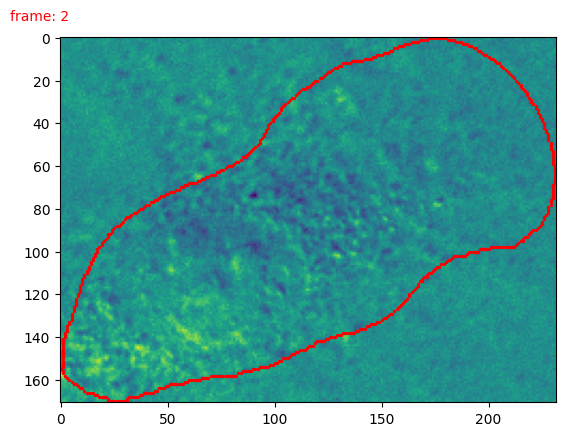

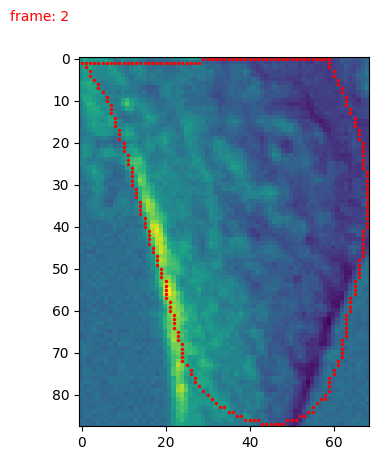

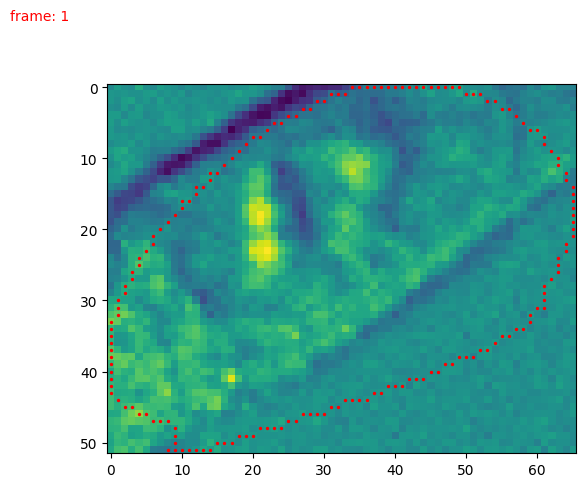

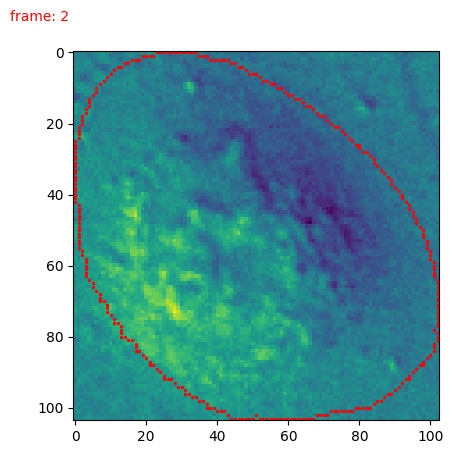

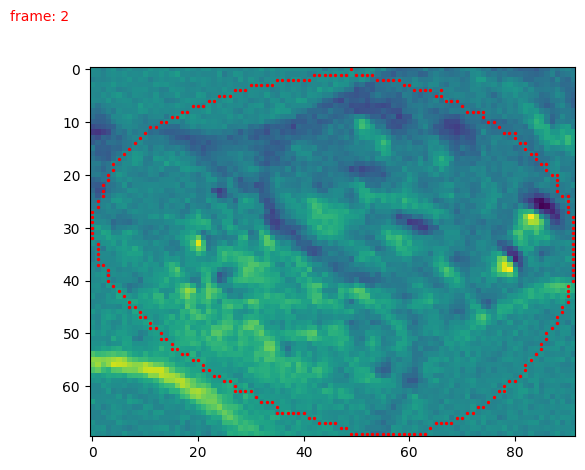

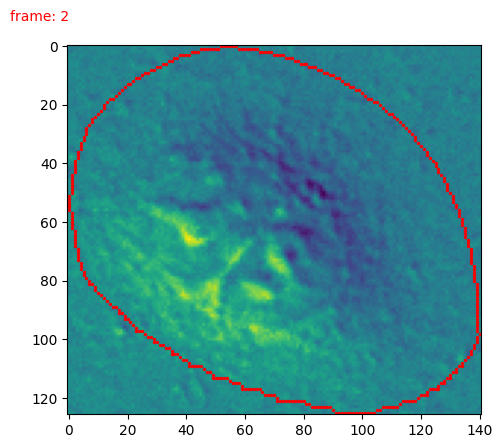

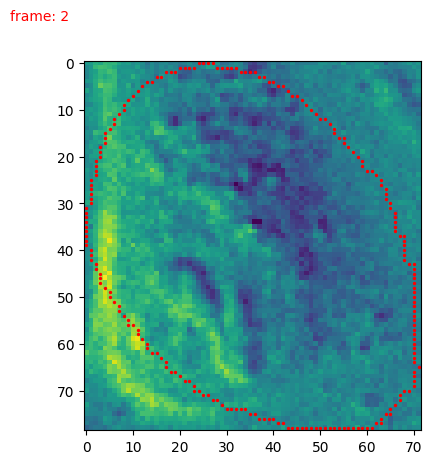

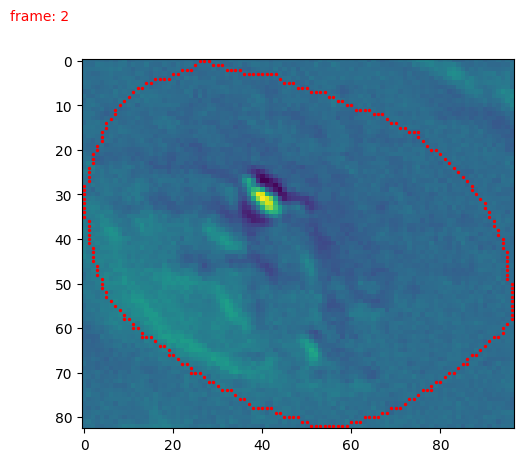

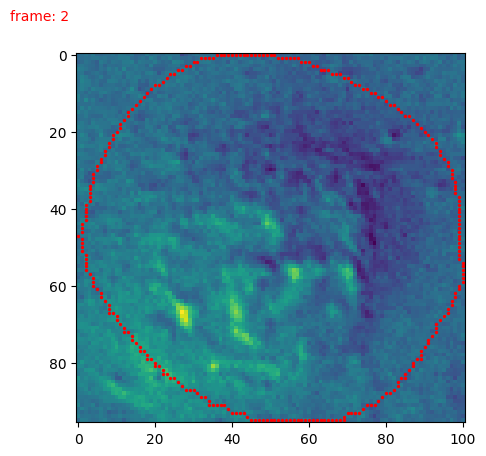

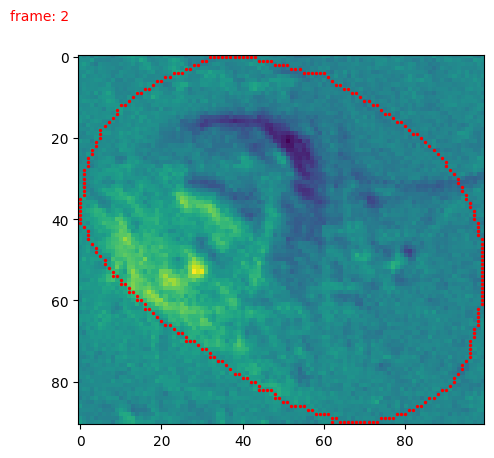

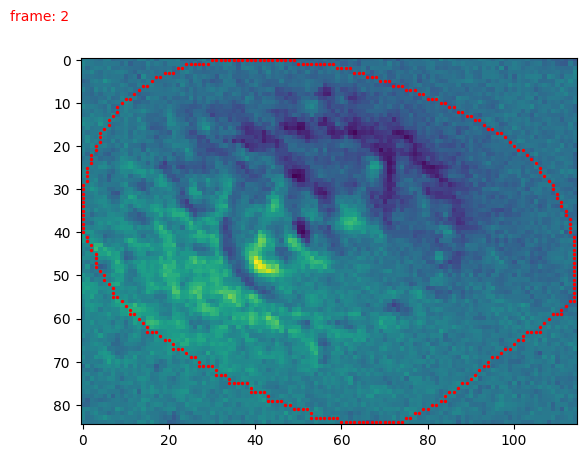

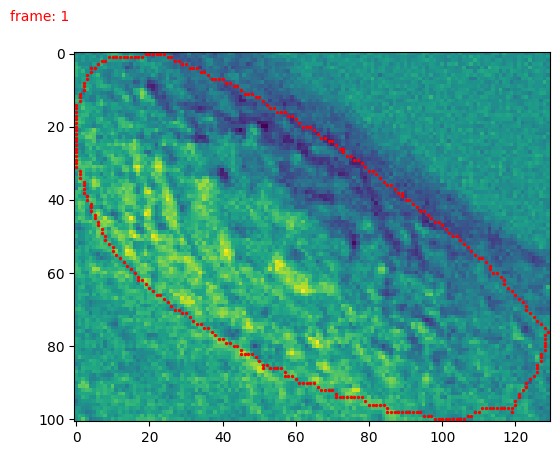

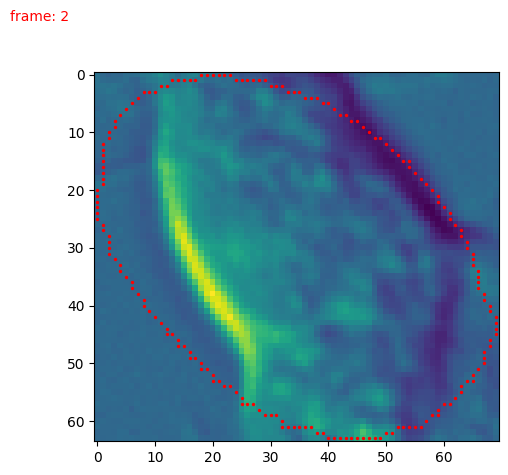

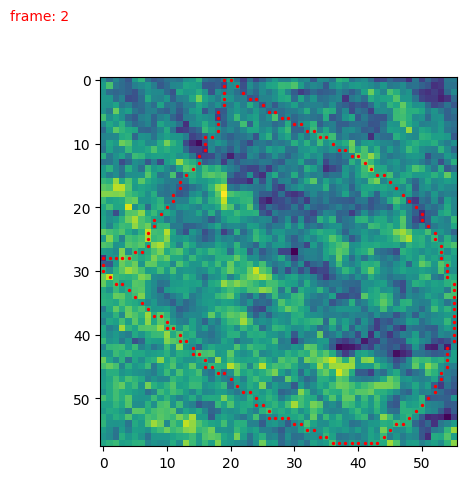

In [20]:
from livecellx.track.movie import generate_single_trajectory_movie

for track_id, traj in traj_collection:
    generate_single_trajectory_movie(traj, save_path=f"./notebook_results/general_tutorial/track_movies/track_{track_id}.gif")

### Trajectory Length Histogram

<Axes: xlabel='Trajectory Length', ylabel='count'>

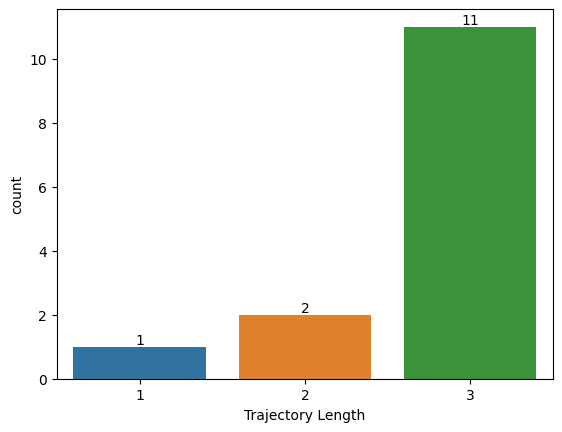

In [21]:
traj_collection.histogram_traj_length()

### Visualizing first frame of each trajectory
By visualizing the first frame of each trajectory, we get a glimpse of the initial state of each cell. 

track_id= 13.0


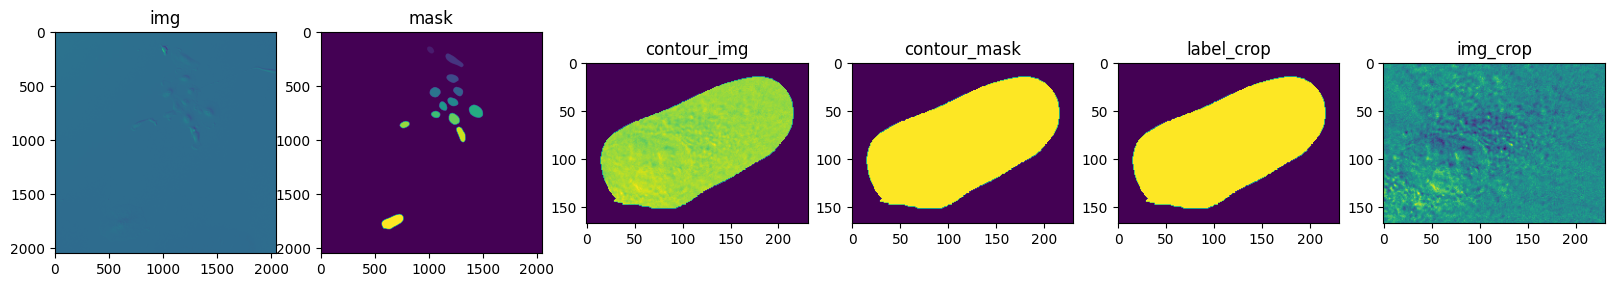

track_id= 12.0


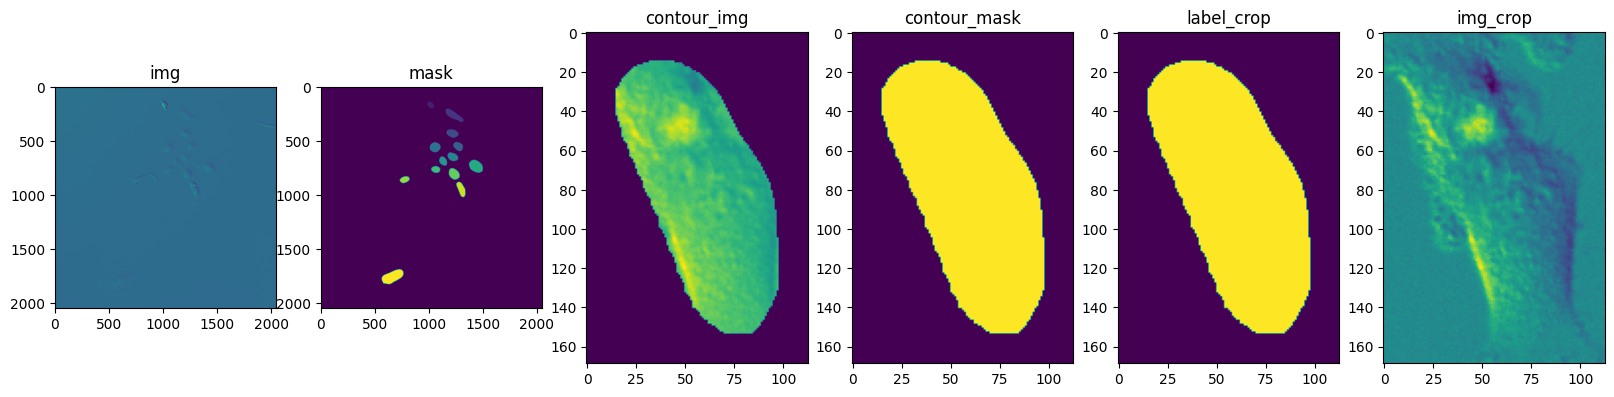

In [22]:
for traj in traj_collection.get_all_trajectories()[0:2]:
    track_id = traj.track_id
    print("track_id=", track_id)
    traj.timeframe_to_single_cell[list(traj.timeframe_to_single_cell.keys())[0]].show_panel(padding=15, figsize=(20, 5))
    plt.show()

import necessary library for the napari viewer

In [23]:
%gui qt
from skimage import data
from livecellx.core.napari_visualizer import NapariVisualizer

import numpy as np
from napari.viewer import Viewer
from livecellx.plot.visualizer import Visualizer
from livecellx.core.single_cell import SingleCellStatic, SingleCellTrajectory, SingleCellTrajectoryCollection


### Manually or programmatically correct trajectories via SCTOperator

In this part, we are setting up Napari to visualize the DIC images alongside the tracked cell trajectories.

In [24]:
import napari
from livecellx.core.sct_operator import SctOperator, create_sct_napari_ui, create_scs_edit_viewer, create_scts_operator_viewer
viewer = napari.view_image(dic_dataset.to_dask(), name="dic_image", cache=True)
shape_layer = NapariVisualizer.gen_trajectories_shapes(traj_collection, viewer, contour_sample_num=20)
shape_layer.mode = "select"

If you would like to apply our correct segmentation model, you need to load a model.

In [25]:
from livecellx.core.sc_seg_operator import ScSegOperator, create_sc_seg_napari_ui
# # replace the path below with your downdloaded CSN checkpoint path
# ckpt_path = r"./notebook_results/csn_models/model_v11_epoch=3282-test_loss=2.3688.ckpt"
# ScSegOperator.load_default_csn_model(path=ckpt_path, cuda=True);

In [26]:
sct_operator = SctOperator(traj_collection, shape_layer, viewer)
# sct_operator.setup_shape_layer(shape_layer)
create_sct_napari_ui(sct_operator)

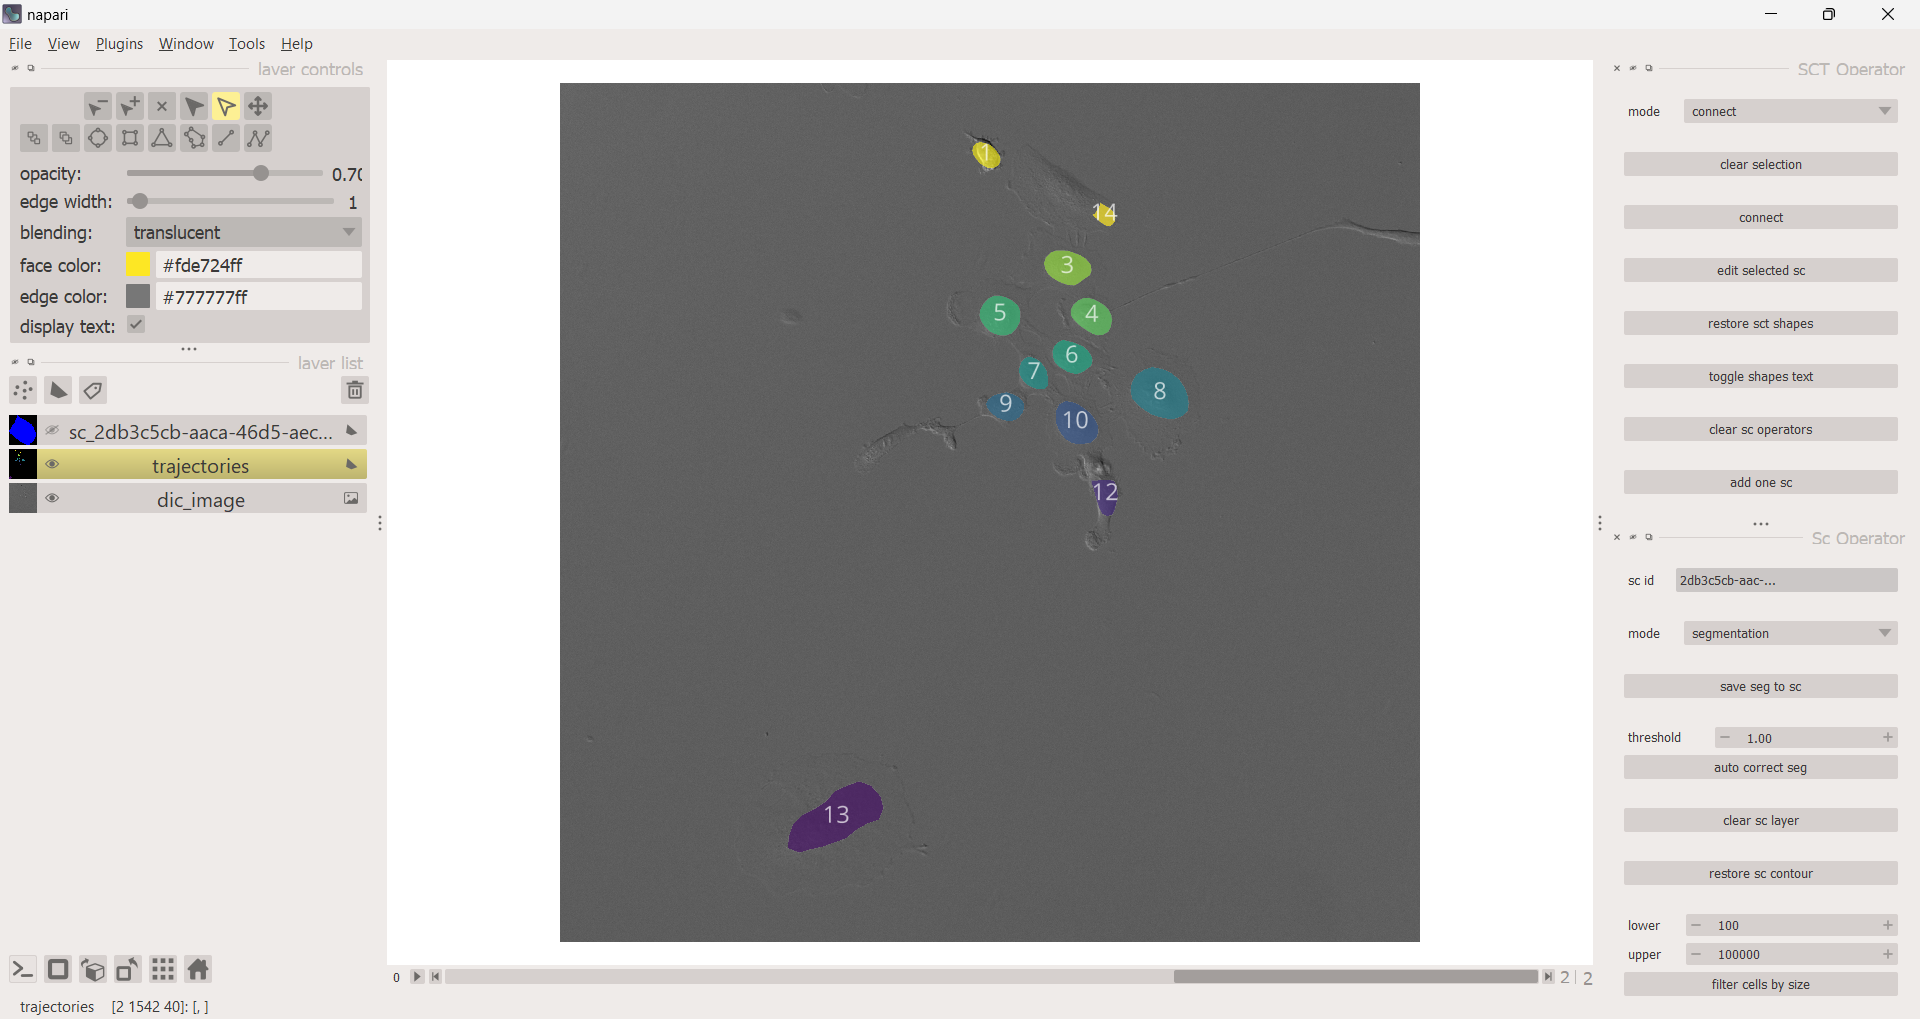
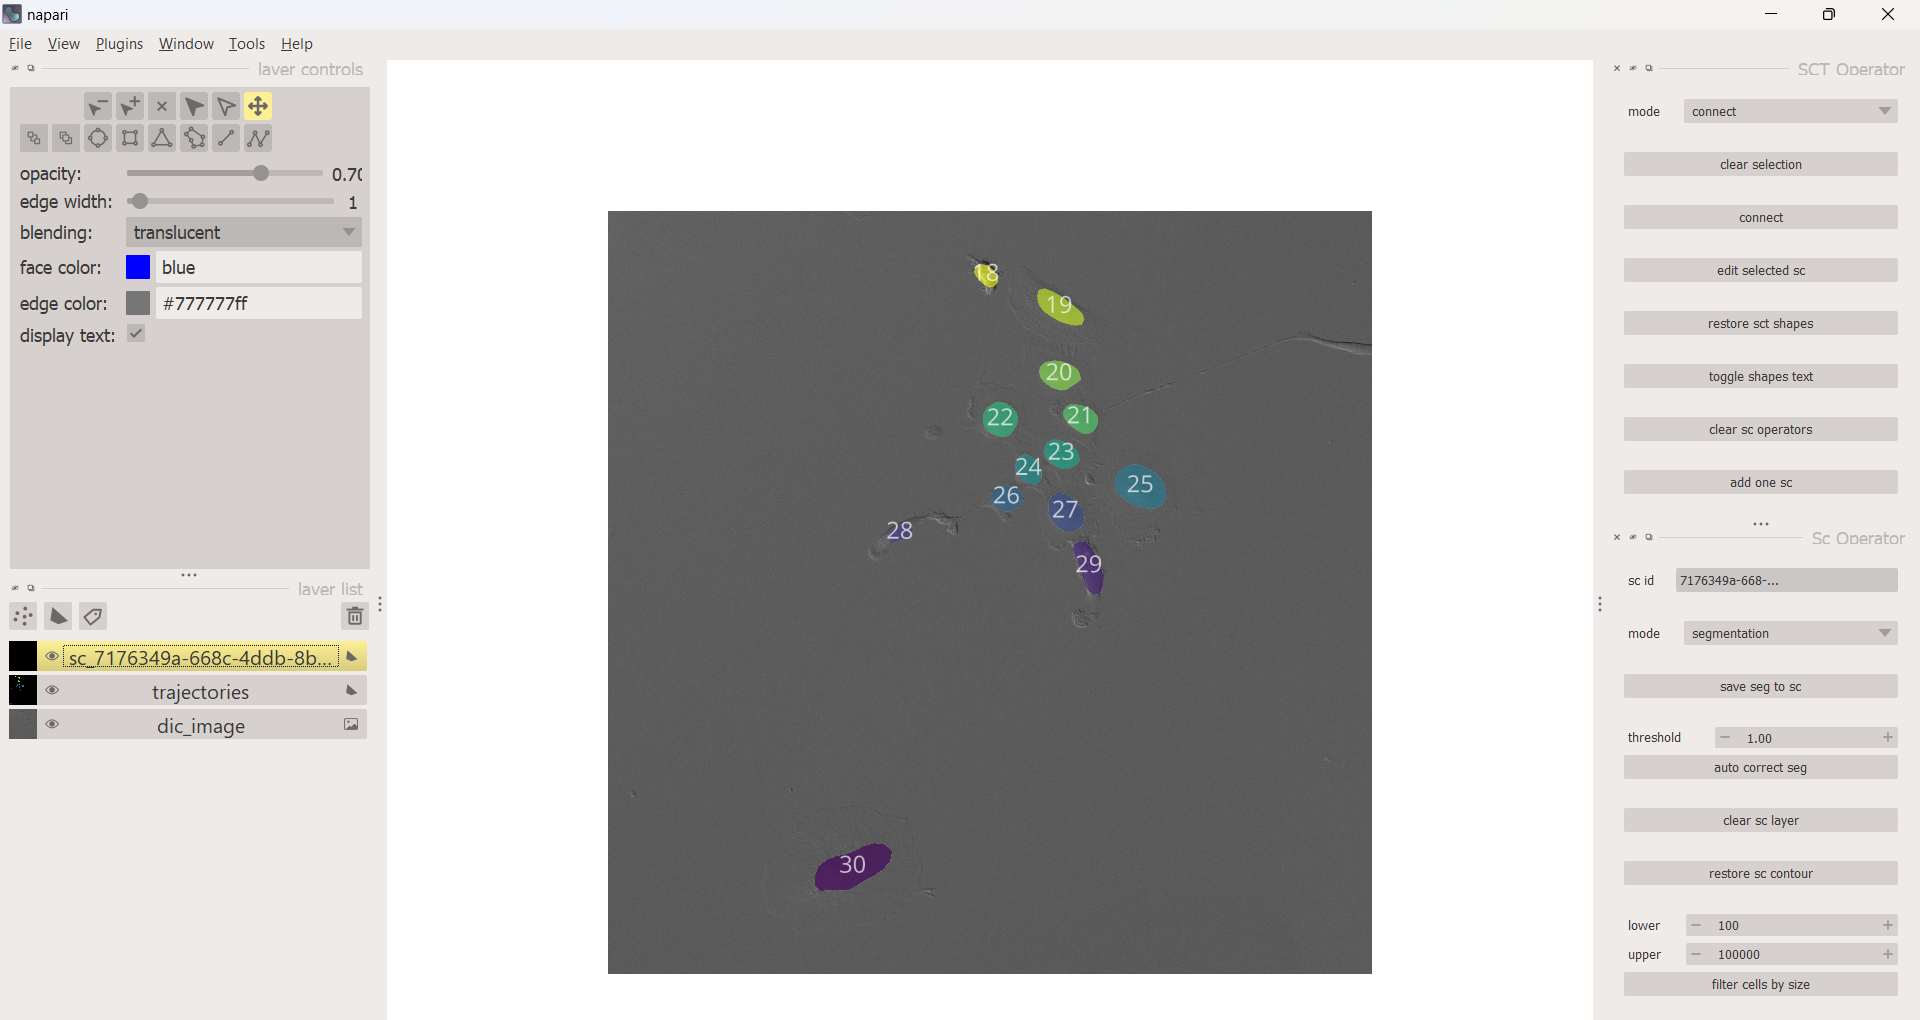
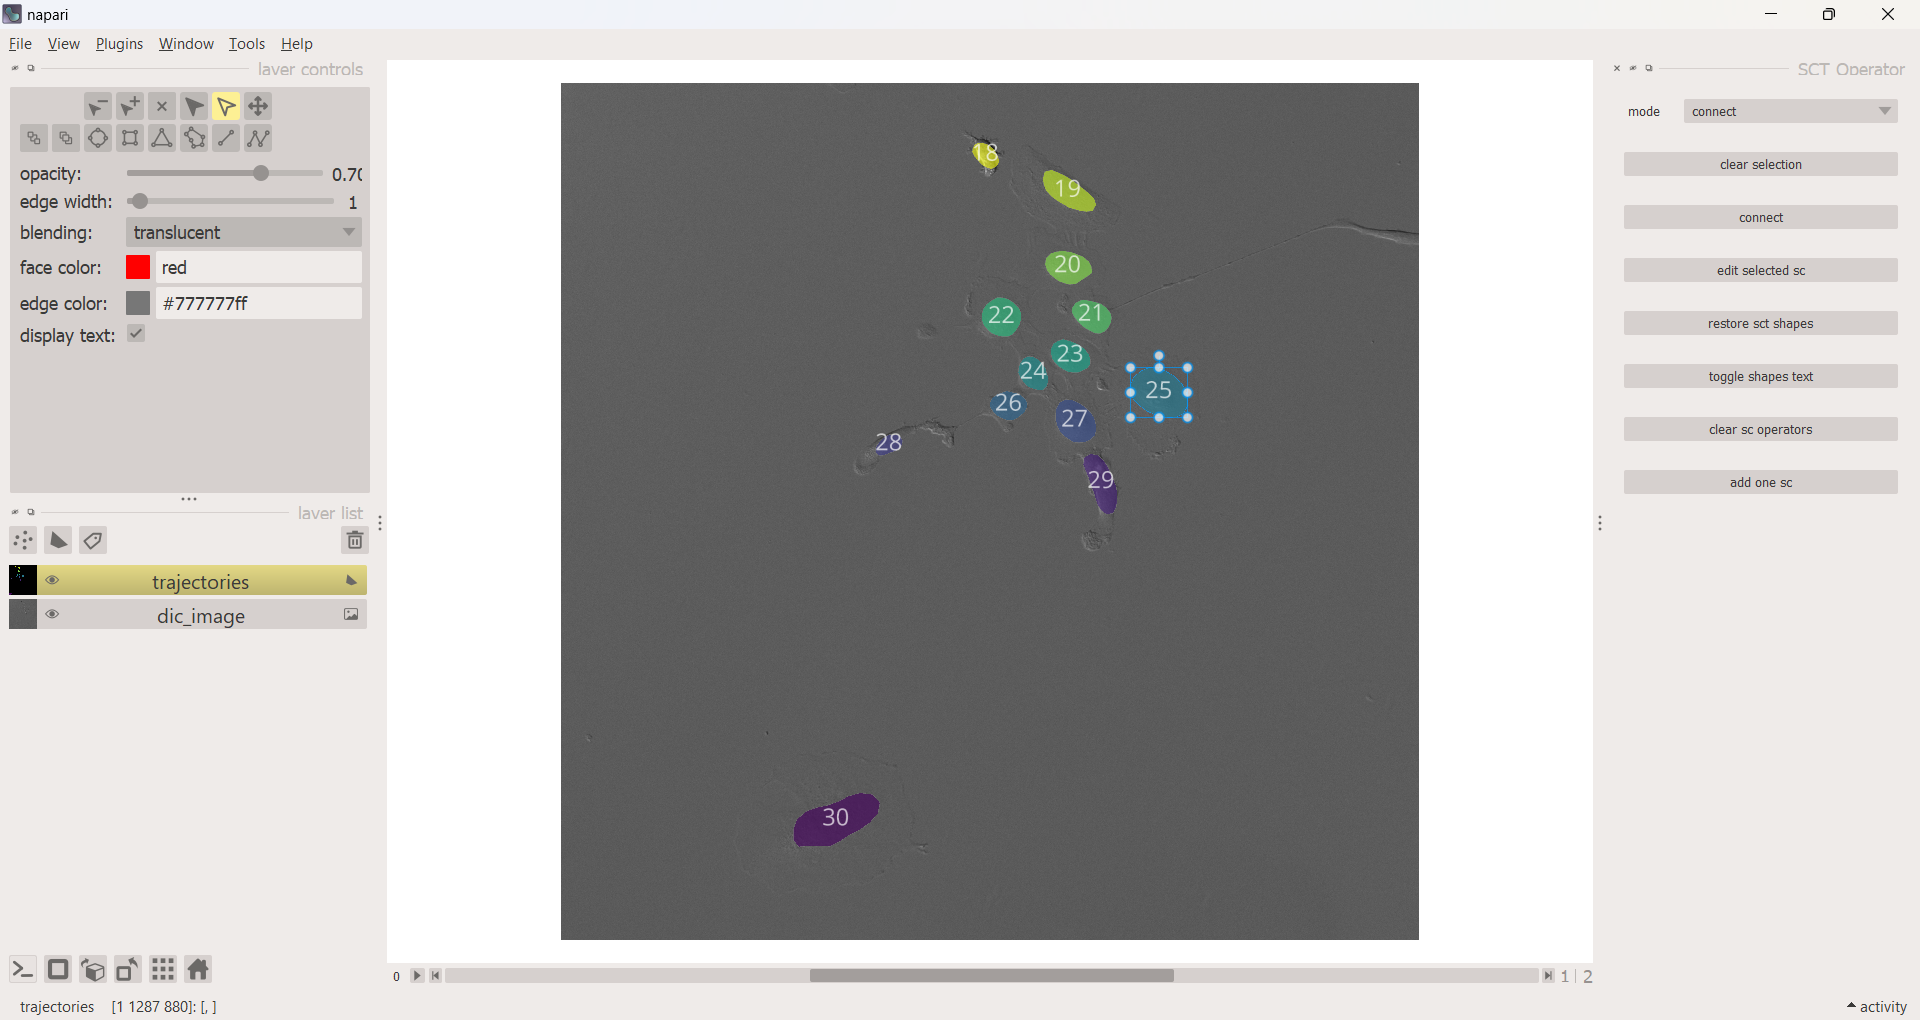

In [27]:
sct_operator.select_shape(None)

current shape layer shape properties:  None
No shape selected, please select a shape to connect trajectories


Select the cell you want to correct. Below picture shows the cell with index 25 selected.
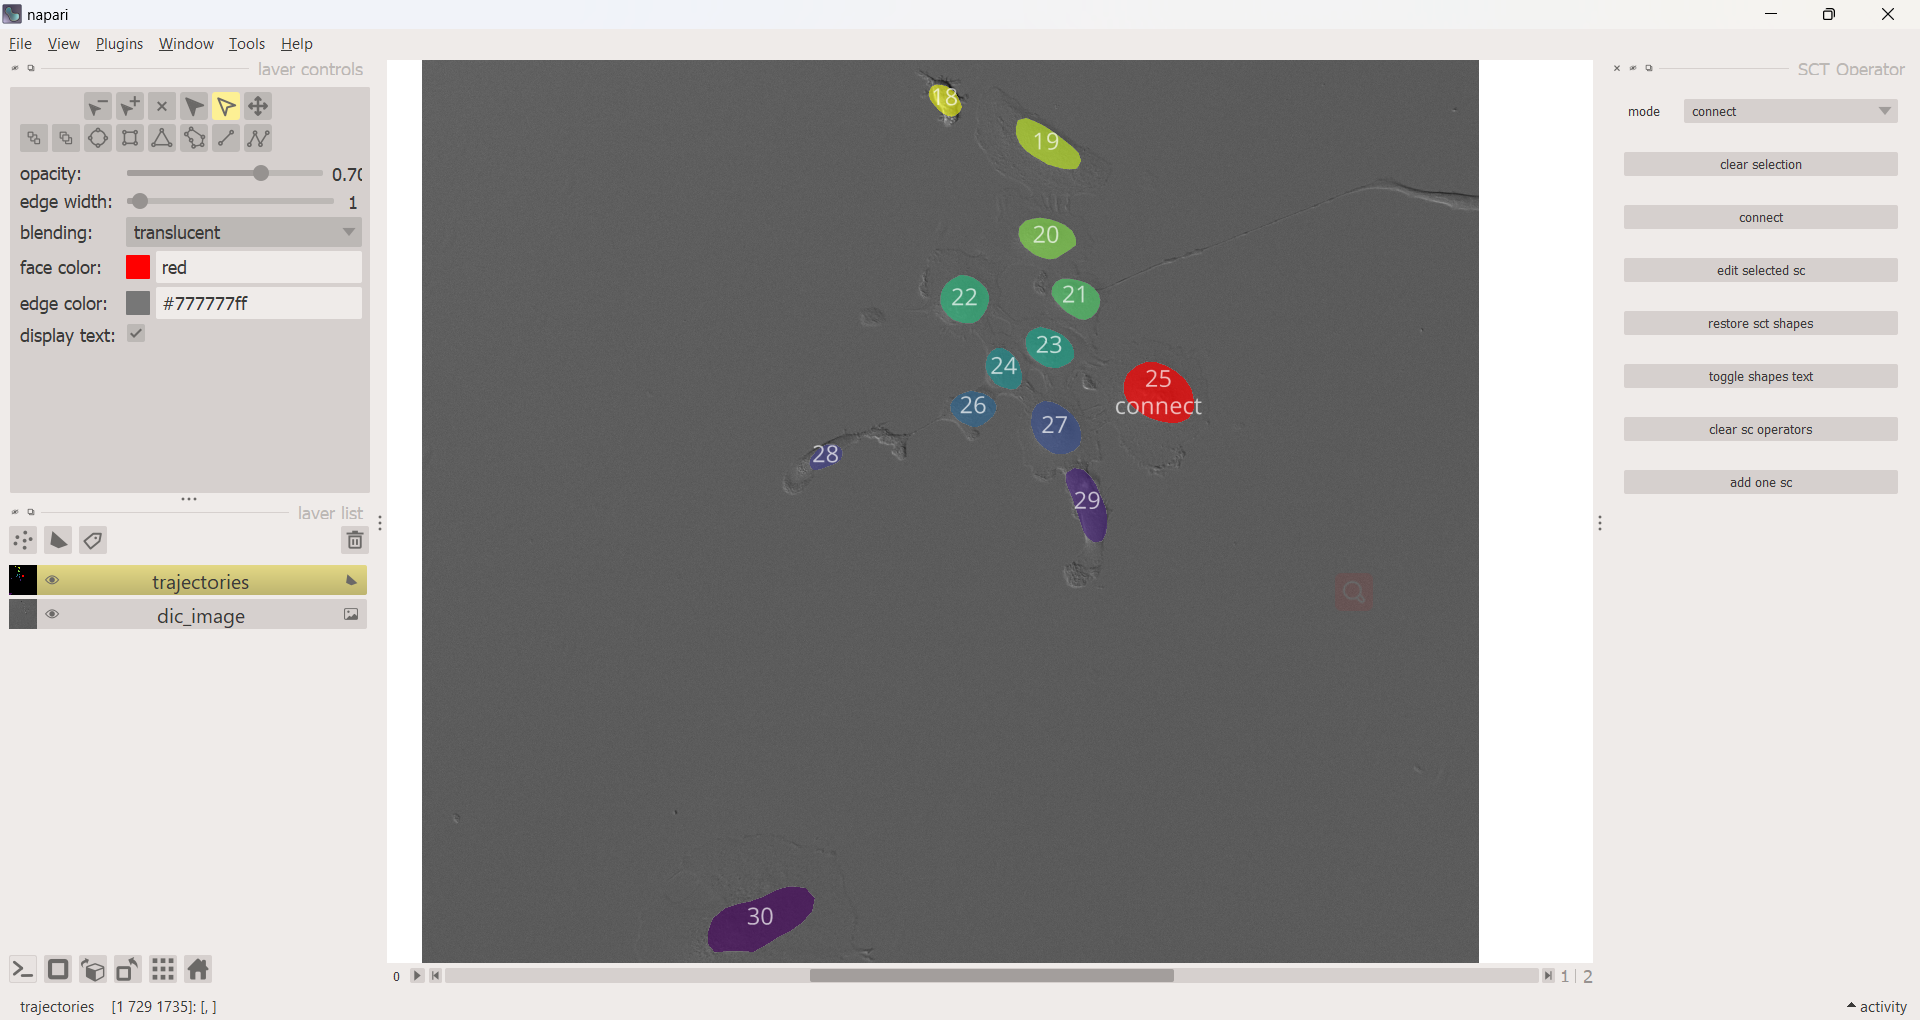

Manually call methods of sct_operator to connect/disconnect/add relations

In [28]:
# sct_operator.connect_two_scts()
# sct_operator.disconnect_sct()
# sct_operator.add_mother_daughter_relation()

Select two cells with the same index but different timeframe and connect them
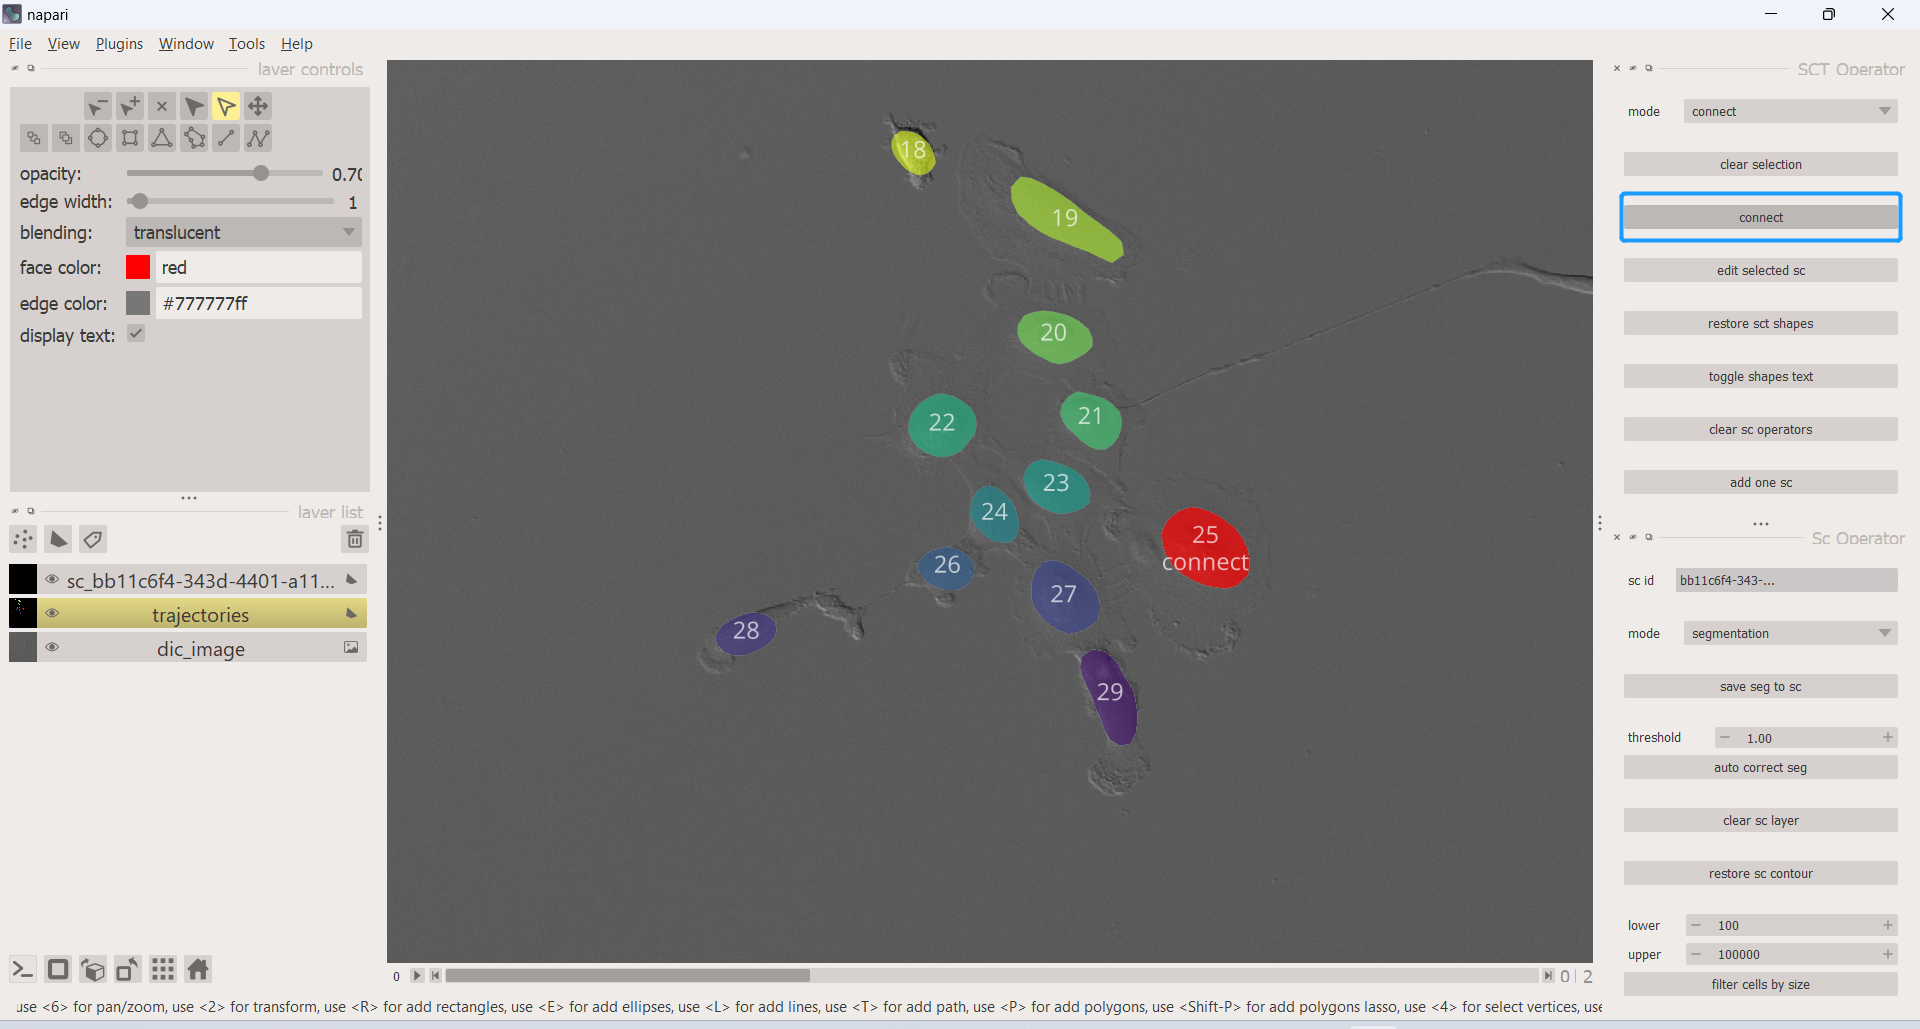

Select one cell to disconnect it from its trajectory
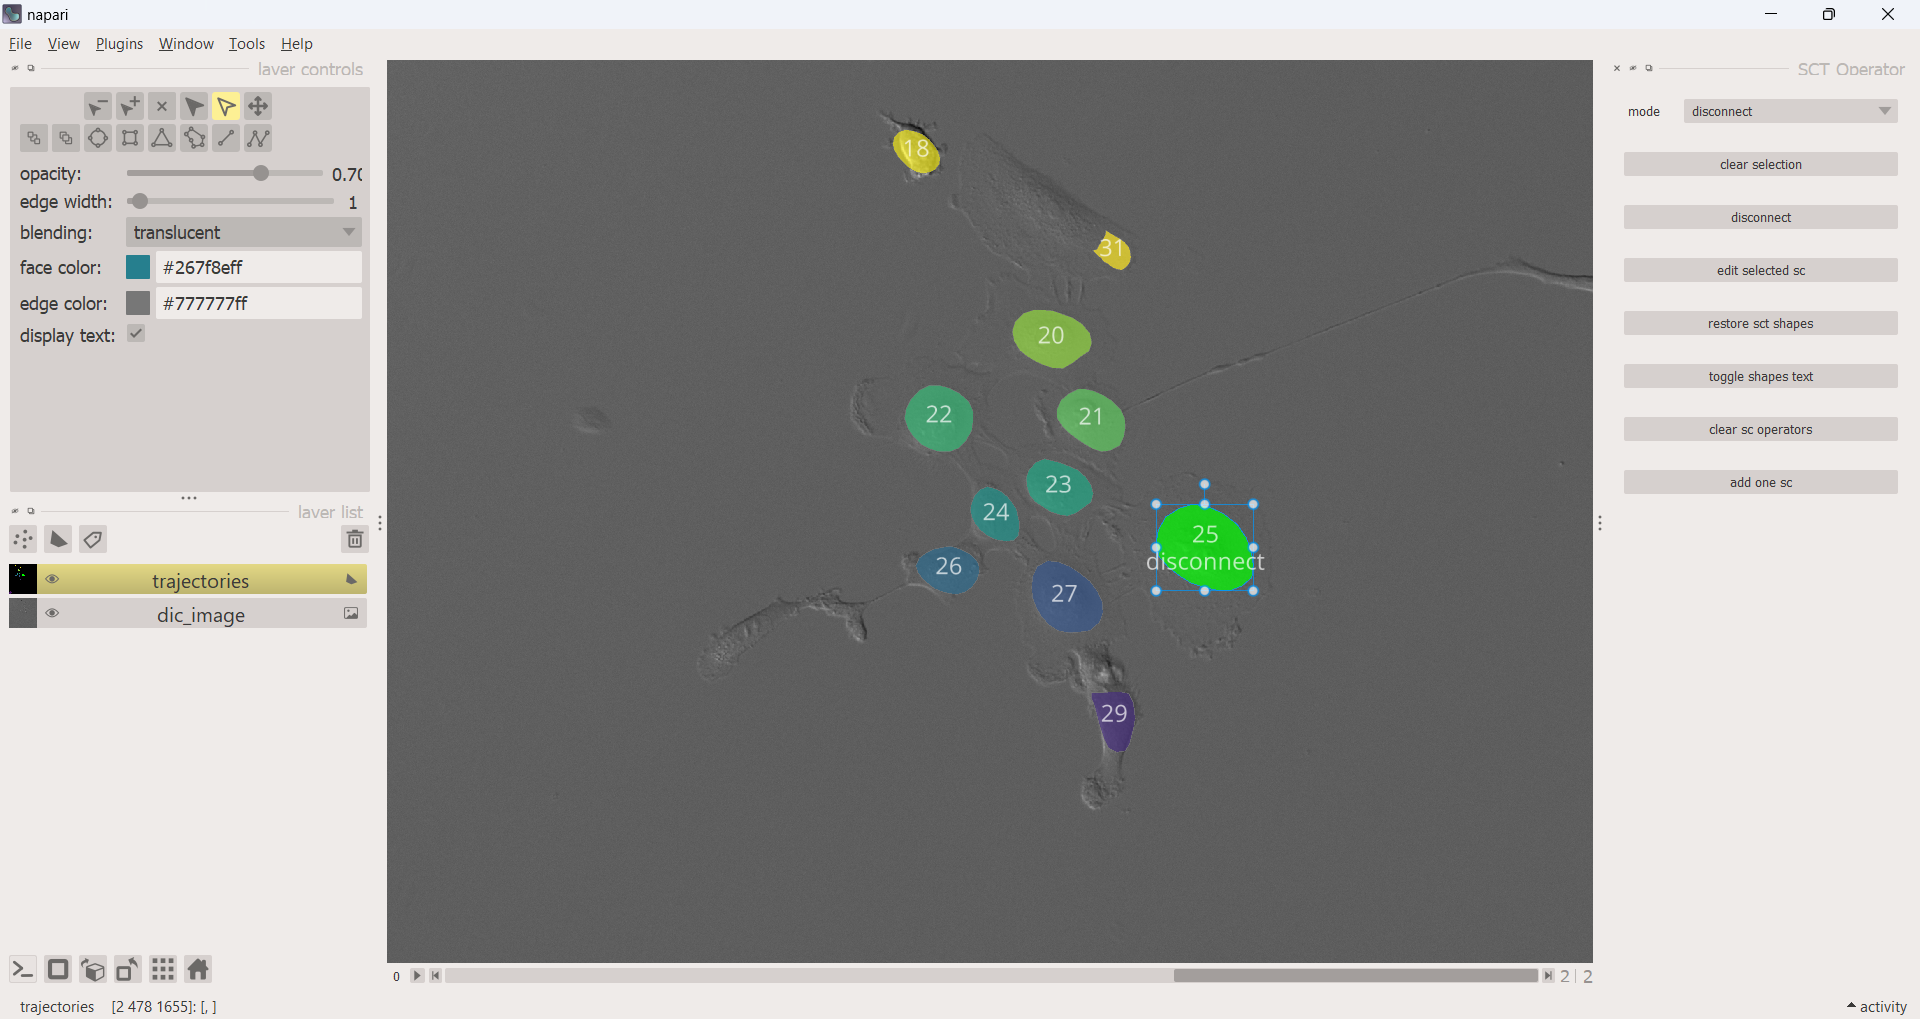

Delete something in Napari and run the following block to observe if the corresponding keys have been deleted from the trajectory collection

In [29]:
sct_operator.traj_collection.track_id_to_trajectory.keys()

dict_keys([13.0, 12.0, 11.0, 10.0, 9.0, 8.0, 7.0, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0, 14.0])

In [30]:
sc_operator = sct_operator.edit_selected_sc()

|-----? More than one shape is selected. The first selected shape is used for editing.
>>> create sc layer done


The right bottom panel `Sc Operator` shows operation you can adopt to edit a single cell.
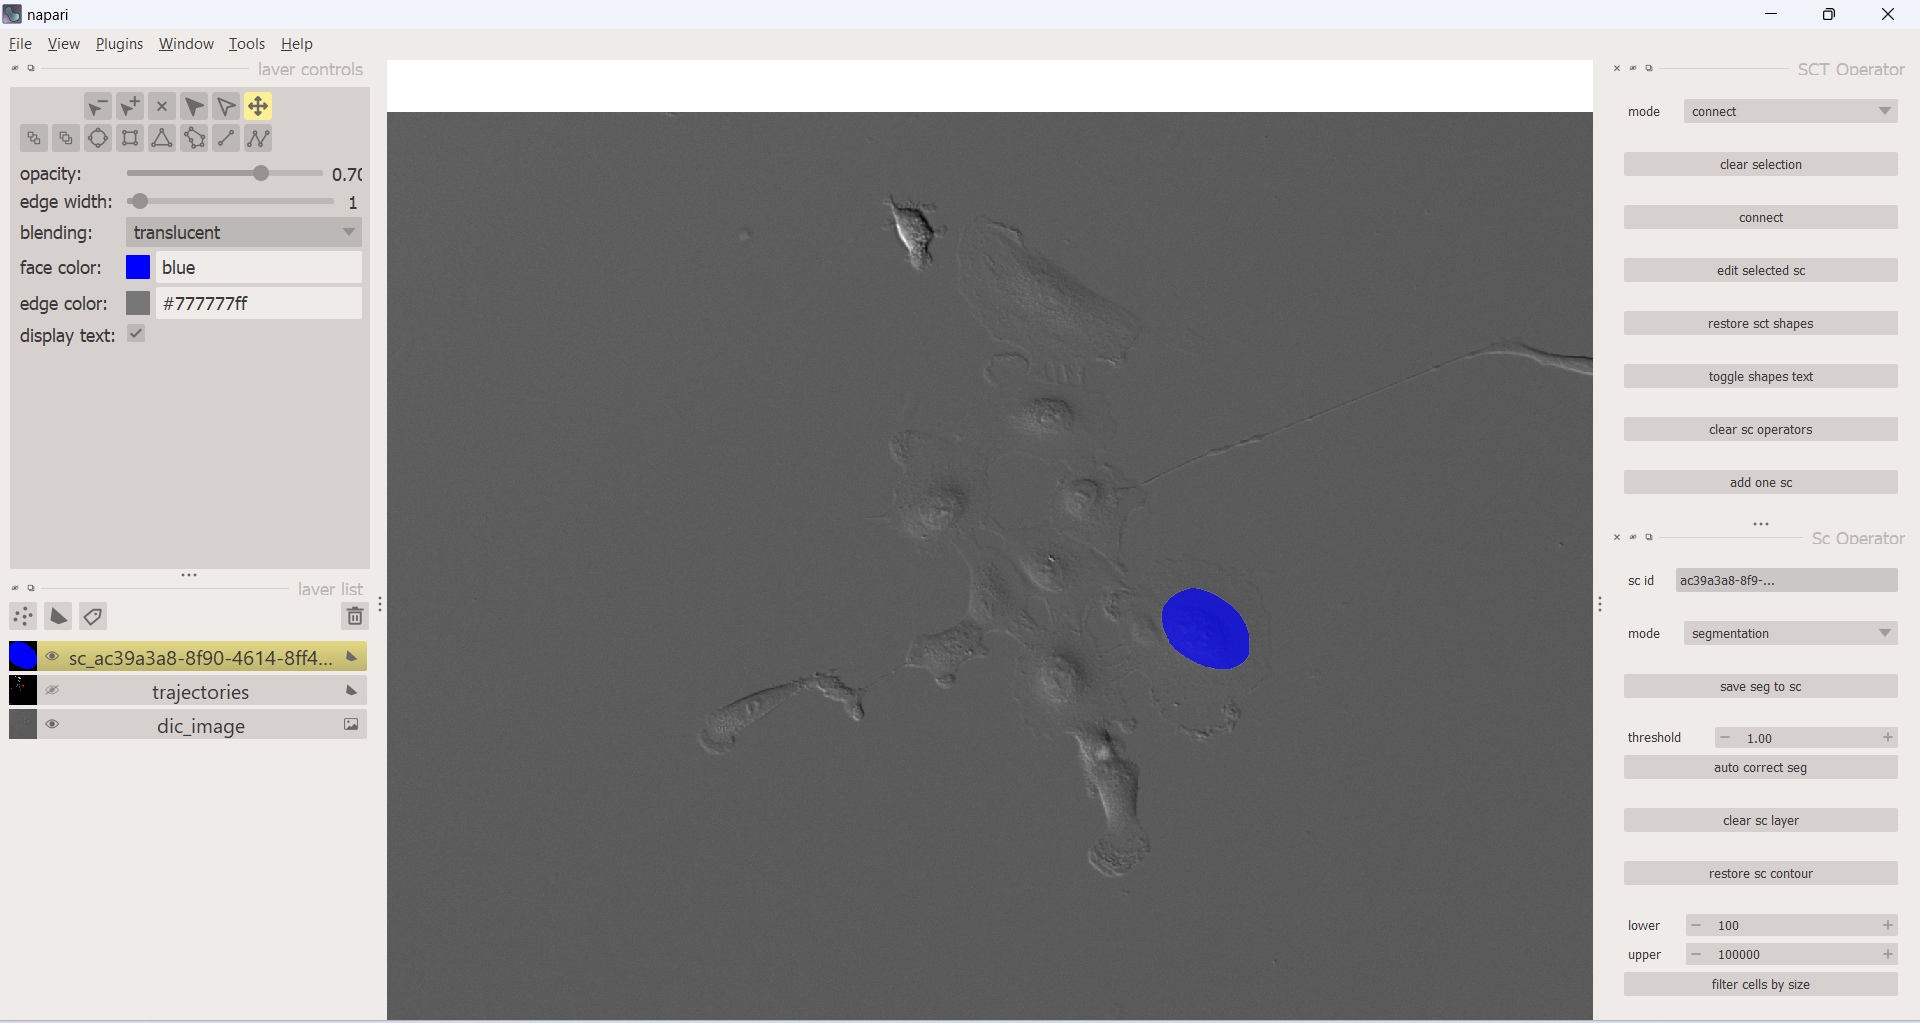

array([<Axes: title={'center': 'img'}>, <Axes: title={'center': 'mask'}>,
       <Axes: title={'center': 'contour_img'}>,
       <Axes: title={'center': 'contour_mask'}>,
       <Axes: title={'center': 'label_crop'}>,
       <Axes: title={'center': 'img_crop'}>], dtype=object)

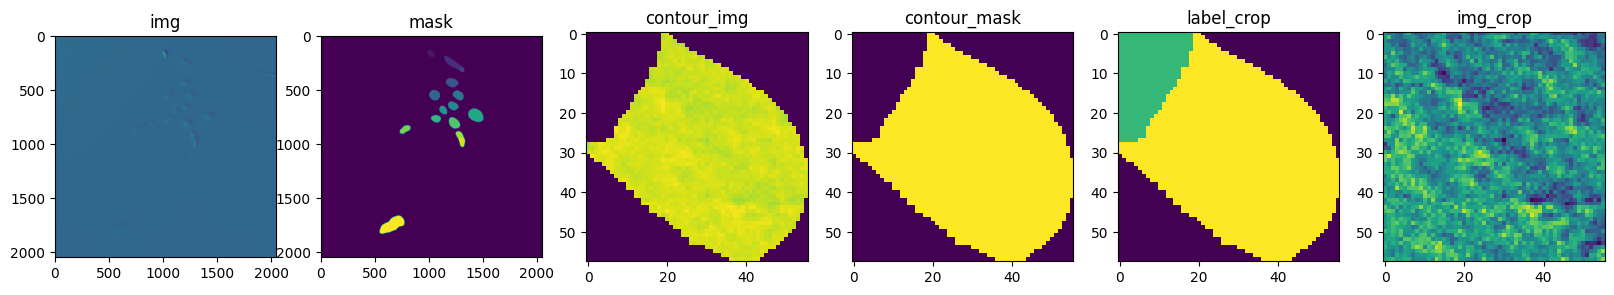

In [31]:
cur_properties = sct_operator.shape_layer.current_properties
cur_properties["sc"]
cur_properties["sc"][0].show_panel()

We can check the current number of single cells and cells selected

In [32]:
len(sct_operator.get_all_scs()), len(sct_operator.select_info)

(38, 0)

If there are any selected single cell trajectories (SCTs) intend to be removed, this can be done using the delete_selected_sct() method. 

In [33]:
sct_operator.delete_selected_sct()

deleting shape...
selected_track_ids:  set()
clearing selection...
<clear complete>
<delete operation complete>


switch mode callback fired!
mode changed to click&annotate
clearing selection...
<clear complete>
